## Import Libraries

In [1]:
import kagglehub
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from scipy import stats
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

c:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import dataset

In [2]:
!pip install kagglehub

# Download dataset langsung dari kaggle
path = kagglehub.dataset_download("raddar/tuberculosis-chest-xrays-shenzhen")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\LENOVO\.cache\kagglehub\datasets\raddar\tuberculosis-chest-xrays-shenzhen\versions\1


Banyak gambar pada dataset :  0

Menganalisis filename untuk menentukan label...
  Ditemukan 0 gambar normal
  Ditemukan 0 gambar TB

⚠️ ERROR: Tidak ditemukan data berlabel

   Sampel Data


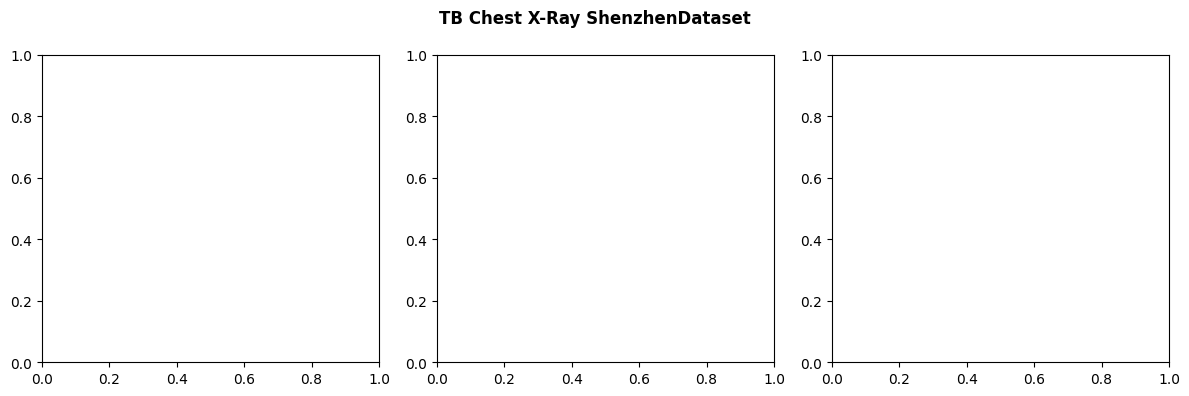

In [3]:
from typing_extensions import dataclass_transform
img_path = "/root/.cache/kagglehub/datasets/raddar/tuberculosis-chest-xrays-shenzhen/versions/1"

data = []
data_files = []
for root, dirs, files in os.walk(img_path):
    for file in files:
        if file.endswith(('.png')):
            data_files.append(os.path.join(root, file))

data_files = sorted(data_files)
print ("Banyak gambar pada dataset : ",len(data_files))

print("\nMenganalisis filename untuk menentukan label...")

# Parsing labels dari filename
normal_count = 0
tb_count = 0

for filepath in data_files:
  basename = os.path.basename(filepath)
  # Sistem penamaan dataset Shenzhen: CHNCXR_0xxx_0.png atau CHNCXR_0xxx_1.png
  # _0 = Normal, _1 = TB
  if '_0.png' in basename:
    label = 0
    normal_count += 1
  elif '_1.png' in basename:
    label = 1
    tb_count += 1
  else:
    # Fallback: check kata kunci
    basename_lower = basename.lower()
    if 'normal' in basename_lower:
      label = 0
      normal_count += 1
    elif 'tb' in basename_lower or 'tuberculosis' in basename_lower:
      label = 1
      tb_count += 1
    else:
      # Jika tidak dapat ditentukan, skip gambar
      print(f"  Warning: Tidak dapat menentukan label untuk {basename}, skipping...")
      continue

  data.append({'path': filepath, 'label': label})

print(f"  Ditemukan {normal_count} gambar normal")
print(f"  Ditemukan {tb_count} gambar TB")

if len(data) == 0:
  print("\n⚠️ ERROR: Tidak ditemukan data berlabel")
  pd.DataFrame(columns=['path', 'label'])

df = pd.DataFrame(data)

#Ambil 3 file paling awal
image_files = data_files[:3]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(image_files)):
    img = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(os.path.basename(data_files[i]))
    axes[i].axis('off')

print("\n   Sampel Data")
plt.suptitle('TB Chest X-Ray ShenzhenDataset', fontweight='bold')
plt.tight_layout()
plt.show()

## Fungsi untuk menampilkan gambar dari folder

In [4]:
def show_images_from_folder(folder_path, title="Sample Images"):
    images = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')])
    if len(images) == 0:
        print(f"Tidak ada gambar di folder {folder_path}")
        return

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()

    for i in range(3):
        img = cv2.imread(images[i], cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(os.path.basename(images[i]))
        axes[i].axis('off')

    plt.suptitle(title, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Membuat folder untuk menyimpan gambar

In [5]:
filter_folder = "filtered_images"
clahe_folder = "filtered_clahe"
output_folder = "output_images"

# Cek folder gambar yang sudah ada
for folder in [filter_folder, clahe_folder, output_folder]:
    if not os.path.exists(folder):
        os.makedirs(folder)

## Preprocessing: Gaussian filter dan CLACHE

In [6]:
# def preprocessing(image_files, filter_folder, clahe_folder, kernel_size=(5,5)):

#   # Itrerasi semua gambar yang ada pada Files
#   for i in range(3):
#     # Mengaplikasikan Gaussian
#     img = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)
#     filtered_img = cv2.GaussianBlur(img, kernel_size, 0.5)

#     # Menyimpan dalam folder
#     filename = os.path.basename(image_files[i])
#     output_path = os.path.join(filter_folder, f"filtered_{filename}")
#     cv2.imwrite(output_path, filtered_img)

#     # Mengaplikasikan CLAHE untuk contrast enhancement
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     enhanced_img = clahe.apply(filtered_img)

#     # Menyimpan dalan folder
#     clahe_path = os.path.join(clahe_folder, f"clahe_{filename}")
#     cv2.imwrite(clahe_path, enhanced_img)

In [7]:
# preprocessing(image_files, filter_folder, clahe_folder,kernel_size=(5, 5))

# # Menampilkan perbandingan gambar
# show_images_from_folder(os.path.dirname(image_files[0]), "Before Gaussian Filtering")
# show_images_from_folder(filter_folder, "After Gaussian Filtering")
# show_images_from_folder(clahe_folder, "After CLAHE Operation")


In [8]:
def preprocessing(img, kernel_size=(5,5)):
    if img is None:
        return None
    # Mengaplikasikan Gaussian
    filtered_img = cv2.GaussianBlur(img, kernel_size, 0.5)

    # Mengaplikasikan CLAHE untuk contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_img = clahe.apply(filtered_img)

    return enhanced_img

## Segmentation

### Otsu thresholding (sensitive segmentation)

In [9]:
def otsu_threshold(image):
  if image is None:
    return None
  _, otsu_thresh_img = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  return otsu_thresh_img

### Global thresholding (insensitive segmentation)

In [10]:
def global_threshold(image, threshold_value=127):
  if image is None:
    return None
  _, global_thresh_img = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
  return global_thresh_img

### Morphological processing (closing)

In [11]:
def closing(binary_mask, kernel_size=(5, 5)):
  if binary_mask is None:
    return None
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
  closed = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
  return closed

## Feature Extraction

### Fitur bentuk (shape fearures)

In [12]:
def extract_shape_features(mask):
  if mask is None:
    return {f'shape_{i}': 0 for i in range(17)} # Return default features if mask is None

  # Memberikan label ke komponen yang terhubung
  labelled_mask = measure.label(mask > 0)
  regions = measure.regionprops(labelled_mask)

  if len(regions) == 0:
    return {f'shape_{i}': 0 for i in range(17)}

  # Mengurutkan region berdasarkan area (asumsikan 2 region dengan area terbesar adalah paru-paru kanan dan kiri)
  regions = sorted(regions, key=lambda x: x.area, reverse=True)[:2]

  features = {}

  if len(regions) >= 2:
    r_left, r_right = regions[0], regions[1]

    # Fitur 1: tinggi
    h_l = r_left.bbox[2] - r_left.bbox[0]
    h_r = r_right.bbox[2] - r_right.bbox[0]
    features['height_left'] = h_l
    features['height_right'] = h_r
    features['height_diff'] = abs(h_l - h_r)

    # Fitur 2: rasio lebar/tinggi (simplified)
    # Ensure h_l and h_r are not zero to prevent division by zero
    features['ratio_left_0'] = r_left.major_axis_length / (h_l + 1e-5) if h_l > 0 else 0
    features['ratio_right_0'] = r_right.major_axis_length / (h_r + 1e-5) if h_r > 0 else 0
    # Only need one ratio for now, or loop it properly. Simplified for existing code structure.
    # The original loop for i in range(5) with same values was likely a placeholder or error.
    for i in range(1, 5):
        features[f'ratio_left_{i}'] = features['ratio_left_0']
        features[f'ratio_right_{i}'] = features['ratio_right_0']

    # Fitur 3: perimeter (keliling)
    features['perimeter_left'] = r_left.perimeter
    features['perimeter_right'] = r_right.perimeter

    # Fitur 4: eccentricity ("keanehan")
    features['eccentricity_left'] = r_left.eccentricity
    features['eccentricity_right'] = r_right.eccentricity
    return features

  else: # jika hanya ada 1 region yang terdeteksi
    r = regions[0]
    h = r.bbox[2] - r.bbox[0]
    features['height_left'] = h
    features['height_right'] = 0
    features['height_diff'] = h

    features['ratio_left_0'] = r.major_axis_length / (h + 1e-5) if h > 0 else 0
    for i in range(1, 5):
        features[f'ratio_left_{i}'] = features['ratio_left_0']
        features[f'ratio_right_{i}'] = 0

    features['perimeter_left'] = r.perimeter
    features['perimeter_right'] = 0

    features['eccentricity_left'] = r.eccentricity
    features['eccentricity_right'] = 0

    return features

### First-order Statistical Features (FOFS)

In [13]:
def fofs(image, mask):
  # Add initial None checks for image and mask
  if image is None or mask is None:
    return {k: 0 for k in ['mean', 'variance', 'std_dev', 'skewness', 'kurtosis', 'entropy', 'smoothness', 'uniformity']}

  # Apply mask ke gambar
  masked_image = cv2.bitwise_and(image, image, mask=mask)

  # Check if masked_image has valid pixels or if the mask is completely empty
  if np.all(masked_image == 0) or not np.any(mask > 0):
    return {k: 0 for k in ['mean', 'variance', 'std_dev', 'skewness', 'kurtosis', 'entropy', 'smoothness', 'uniformity']}

  pixels = masked_image[mask > 0]

  if len(pixels) == 0:
    return {k: 0 for k in ['mean', 'variance', 'std_dev', 'skewness', 'kurtosis', 'entropy', 'smoothness', 'uniformity']}

  # Menghitung fitur statistik
  mean = np.mean(pixels)
  variance = np.var(pixels)
  std_dev = np.std(pixels)
  skewness = stats.skew(pixels)
  kurtosis = stats.kurtosis(pixels)

  # Fitur histogram
  hist, _ = np.histogram(pixels, bins=255, range=(0, 256), density=True)
  hist = hist[hist > 0]
  entropy = -np.sum(hist * np.log2(hist + 1e-10)) # Corrected line
  smoothness = 1 - (1 / (1 + variance))
  uniformity = np.sum(hist ** 2)

  return {
      'mean' : mean,
      'variance' : variance,
      'std_dev' : std_dev,
      'skewness' : skewness,
      'kurtosis': kurtosis,
      'entropy' : entropy,
      'smoothness' : smoothness,
      'uniformity' : uniformity
  }

### Gray-Level Co-occurence Matrix (GLCM)

In [14]:
def glcm(image, mask):
  # Add initial None checks for image and mask
  if image is None or mask is None:
    return {f'glcm_{prop}_{angle}' : 0 for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM'] for angle in ['0', '45', '90', '135']}

  # Apply mask to the image
  masked_image = cv2.bitwise_and(image, image, mask=mask)

  # Check if masked_image is effectively empty (all zeros) after masking
  if np.all(masked_image == 0):
      return {f'glcm_{prop}_{angle}' : 0 for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM'] for angle in ['0', '45', '90', '135']}

  # Normalize the image to 8-bit. Handle cases where normalization might be problematic.
  # Ensure there are non-zero pixels before attempting normalization based on min/max.
  min_val = np.min(masked_image[masked_image > 0]) if np.any(masked_image > 0) else 0
  max_val = np.max(masked_image) if np.any(masked_image > 0) else 0

  # If no meaningful pixel data (e.g., all pixels are the same or zero after mask),
  # return default features.
  if max_val == 0 or min_val == max_val:
      return {f'glcm_{prop}_{angle}' : 0 for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM'] for angle in ['0', '45', '90', '135']}

  # Perform normalization safely
  img_8bit = cv2.normalize(masked_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

  # GLCM in 4 directions (0, 45, 90, 135)
  distances = [1]
  angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

  # Check if img_8bit is suitable for graycomatrix (needs at least 2 unique gray levels for meaningful GLCM)
  if img_8bit.size == 0 or len(np.unique(img_8bit)) < 2:
      return {f'glcm_{prop}_{angle}' : 0 for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM'] for angle in ['0', '45', '90', '135']}

  glcm = graycomatrix(img_8bit, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

  # Extract properties
  features = {}
  properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

  for prop in properties:
    values = graycoprops(glcm, prop)
    for i, angle in enumerate(['0', '45', '90', '135']):
      features[f'glcm_{prop}_{angle}'] = values[0, i]

  return features

## Pipeline

In [15]:
def process_single_image(image_path):
  if not isinstance(image_path, str):
    print("Invalid path:", image_path)
    return None

  if not os.path.exists(image_path):
    print("Path not found:", image_path)
    return None

  # load
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  if img is None:
    print("OpenCV cannot read:", image_path)
    return None

  # 1. Preprocessing
  # Pass the loaded image 'img' to preprocessing to avoid redundant loading
  enhanced = preprocessing(img)
  if enhanced is None:
    print(f"Preprocessing failed for {image_path}")
    return None

  # 2. Segmentation (Sensitive)
  otsu_mask = otsu_threshold(enhanced)
  if otsu_mask is None:
    print(f"Otsu thresholding failed for {image_path}")
    return None
  closed_otsu = closing(otsu_mask)
  if closed_otsu is None:
    print(f"Closing (Otsu) failed for {image_path}")
    return None

  # 3. Segmentation (Insensitive)
  global_mask = global_threshold(enhanced)
  if global_mask is None:
    print(f"Global thresholding failed for {image_path}")
    return None
  closed_global = closing(global_mask)
  if closed_global is None:
    print(f"Closing (Global) failed for {image_path}")
    return None

  # 4. Feature extraction
  # These functions are now expected to return dictionaries (possibly with default/zero values) or handle their own None inputs
  shape_featues = extract_shape_features(closed_otsu)
  fofs_features = fofs(enhanced, closed_global)
  glcm_features = glcm(enhanced, closed_global)

  # Gabungkan semua fitur - now safer as all feature functions should return dicts
  all_features = {**shape_featues, **fofs_features, **glcm_features}

  return all_features

In [16]:
def extract_dataset(df, limit=None):
  features_list = []
  labels = []

  total = len(df) if limit is None else min(limit, len(df))

  for idx, row in df.iterrows():
    if limit and idx >= limit:
      break

    if idx % 50 == 0:
      print(f"Processing image {idx+1}/{total}...")

    features = process_single_image(row['path'])
    if features is not None:
      features_list.append(features)
      labels.append(row['label'])

  # Konversi ke dataframe
  features_df = pd.DataFrame(features_list)
  features_df['label'] = labels

  print(f"\nFeature extraction selesai!")
  print(f"Total fitur yang diekstrak: {len(features_df.columns)-1}")

  return features_df

### Klasifikasi hierarkis

In [17]:
class klasifikasiHierarkis:
  """
  Implementasi:
  Stage 1: Klasifikasi berdasarkan fitur-fitur bentuk (shape features)
  Stage 2: Jika stage 1 = normal, cek dengan semua fitur
  """

  def __init__(self, model_type='svm'):
    self.model_type = model_type
    self.stage1_model = None # Shape feature
    self.stage2_model = None # Semua fitur
    self.scaler1 = StandardScaler()
    self.scaler2 = StandardScaler()

  def fit(self, X, y):
    """
    Training model secara hierarkis
    X: Dataframe dengan semua fitur
    y: label
    """
    # Identifikasi kolom shape features
    shape_cols = [col for col in X.columns if 'height' in col or
                  'ratio' in col or 'perimeter' in col or 'eccentricity' in col]

    X_shape = X[shape_cols]
    X_all = X

    # Fitur skalar
    X_shape_scaled = self.scaler1.fit_transform(X_shape)
    X_all_scaled = self.scaler2.fit_transform(X_all)

    # Training model Stage 1
    if self.model_type == 'svm':
      self.stage1_model = SVC(kernel='rbf', probability=True, random_state=42)
      self.stage2_model = SVC(kernel='rbf', probability=True, random_state=42)
    else:
      self.stage1_model = GaussianNB()
      self.stage2_model = GaussianNB()

    self.stage1_model.fit(X_shape_scaled, y)
    self.stage2_model.fit(X_all_scaled, y)

    print(f"Stage 1 ({self.model_type}) trained on {len(shape_cols)} fitur-fitur bentuk (shape features)")
    print(f"Stage 2 ({self.model_type}) trained on {X_all.shape[1]} semua fitur")

    return self

  def predict(self, X):
    """
    Prediksi Hierarkis
    """
    shape_cols = [col for col in X.columns if 'height' in col or
                   'ratio' in col or 'perimeter' in col or 'eccentricity' in col]

    X_shape = X[shape_cols]
    X_all = X

    X_shape_scaled = self.scaler1.transform(X_shape)
    X_all_scaled = self.scaler2.transform(X_all)

    # Stage 1: Prediksi dengan fitur-fitur bentuk (shape features)
    stage1_pred = self.stage1_model.predict(X_shape_scaled)
    stage1_proba = self.stage1_model.predict_proba(X_shape_scaled)[:, 1]

    # Stage 2: Untuk case yang diprediksi normal, cek lagi dengan semua fitur
    final_pred = stage1_pred.copy()
    for i in range(len(stage1_pred)):
      if stage1_pred[i] == 0:  # Prediksi = normal
        # Gunakan hasil stage 2 untuk prediksi final
        stage2_pred = self.stage2_model.predict(X_all_scaled[i:i+1])
        final_pred[i] = stage2_pred[0]

    return final_pred

  def predict_proba(self, X):
    """Get probabilitas prediksi"""
    predictions = self.predict(X)
    proba = np.zeros((len(predictions), 2))
    proba[predictions == 0, 0] = 1
    proba[predictions == 1, 1] = 1
    return proba

### Evaluasi dan perbandingan

In [18]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Evaluate model performance
    """
    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*60}")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)

    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,
                               target_names=['Normal', 'TB']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'TB'],
                yticklabels=['Normal', 'TB'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return accuracy, y_pred

In [19]:
def main():
    """
    Main execution function
    """
    print("="*60)
    print("TB DETECTION WITH HIERARCHICAL FEATURE EXTRACTION")
    print("="*60)

    # Initialize pipeline

    # Load data
    df = pd.DataFrame(data)
    # Shuffle the dataframe to ensure both classes are likely included when a limit is applied
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Extract features
    print("\n" + "="*60)
    print("EXTRACTING FEATURES...")
    print("="*60)
    features_df = extract_dataset(df, limit=100)

    # Prepare data for training
    X = features_df.drop('label', axis=1)
    y = features_df['label']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nTrain set: {len(X_train)} images")
    print(f"Test set: {len(X_test)} images")

    # Train and evaluate models
    print("\n" + "="*60)
    print("TRAINING AND EVALUATION")
    print("="*60)

    # SVM with Hierarchical Classification
    svm_model = klasifikasiHierarkis(model_type='svm')
    svm_acc, svm_pred = evaluate_model(svm_model, X_train, X_test,
                                       y_train, y_test,
                                       "SVM (Hierarchical)")

    # Naive Bayes with Hierarchical Classification
    nb_model = klasifikasiHierarkis(model_type='nb')
    nb_acc, nb_pred = evaluate_model(nb_model, X_train, X_test,
                                     y_train, y_test,
                                     "Naive Bayes (Hierarchical)")

    # Comparison
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    comparison_df = pd.DataFrame({
        'Model': ['SVM', 'Naive Bayes'],
        'Accuracy': [svm_acc, nb_acc]
    })
    print(comparison_df.to_string(index=False))

    # Visualization
    plt.figure(figsize=(8, 5))
    plt.bar(comparison_df['Model'], comparison_df['Accuracy'],
            color=['#2E86AB', '#A23B72'])
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.ylim([0, 1])
    for i, v in enumerate(comparison_df['Accuracy']):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

if __name__ == "__main__":
    main()

TB DETECTION WITH HIERARCHICAL FEATURE EXTRACTION

EXTRACTING FEATURES...

Feature extraction selesai!
Total fitur yang diekstrak: 0


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:

    """
    Main execution function
    """
    print("="*60)
    print("TB DETECTION WITH HIERARCHICAL FEATURE EXTRACTION")
    print("="*60)

    # Initialize pipeline

    # Load data
    df = pd.DataFrame(data)
    # Shuffle the dataframe to ensure both classes are likely included when a limit is applied
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Extract features
    print("\n" + "="*60)
    print("EXTRACTING FEATURES...")
    print("="*60)
    features_df = extract_dataset(df)

    # Prepare data for training
    X = features_df.drop('label', axis=1)
    y = features_df['label']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nTrain set: {len(X_train)} images")
    print(f"Test set: {len(X_test)} images")

    # Train and evaluate models
    print("\n" + "="*60)
    print("TRAINING AND EVALUATION")
    print("="*60)

    # SVM with Hierarchical Classification
    svm_model = klasifikasiHierarkis(model_type='svm')
    svm_acc, svm_pred = evaluate_model(svm_model, X_train, X_test,
                                       y_train, y_test,
                                       "SVM (Hierarchical)")

    # Naive Bayes with Hierarchical Classification
    nb_model = klasifikasiHierarkis(model_type='nb')
    nb_acc, nb_pred = evaluate_model(nb_model, X_train, X_test,
                                     y_train, y_test,
                                     "Naive Bayes (Hierarchical)")

    # Comparison
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    comparison_df = pd.DataFrame({
        'Model': ['SVM', 'Naive Bayes'],
        'Accuracy': [svm_acc, nb_acc]
    })
    print(comparison_df.to_string(index=False))

    # Visualization
    plt.figure(figsize=(8, 5))
    plt.bar(comparison_df['Model'], comparison_df['Accuracy'],
            color=['#2E86AB', '#A23B72'])
    plt.ylabel('Accuracy')
    plt.title('Model Performance Comparison')
    plt.ylim([0, 1])
    for i, v in enumerate(comparison_df['Accuracy']):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

